Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 
Objective: 6142802.650871479
solve_result:  solved
Objective:  6142802.650871479
solve_result:  solved
Solve_time: 0.33038500000000004 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model


The license for this AMPL processor will expire in 5.8 days.


Objective: 6142802.650871482
solve_result:  solved
Objective:  6142802.650871482
solve_result:  solved
Solve_time: 0.016282999999999936

Presolve the model for fixing the arc direction
Is node 1 in cycle? False
Fix the arc (1, 2)
Is node 2 in cycle? False
Fix the arc (2, 3)
Is node 3 in cycle? True
Fix the arc (3, 4)
Fix the arc (3, 19)
Fix the arc (3, 20)
fixed arc direction: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)] 



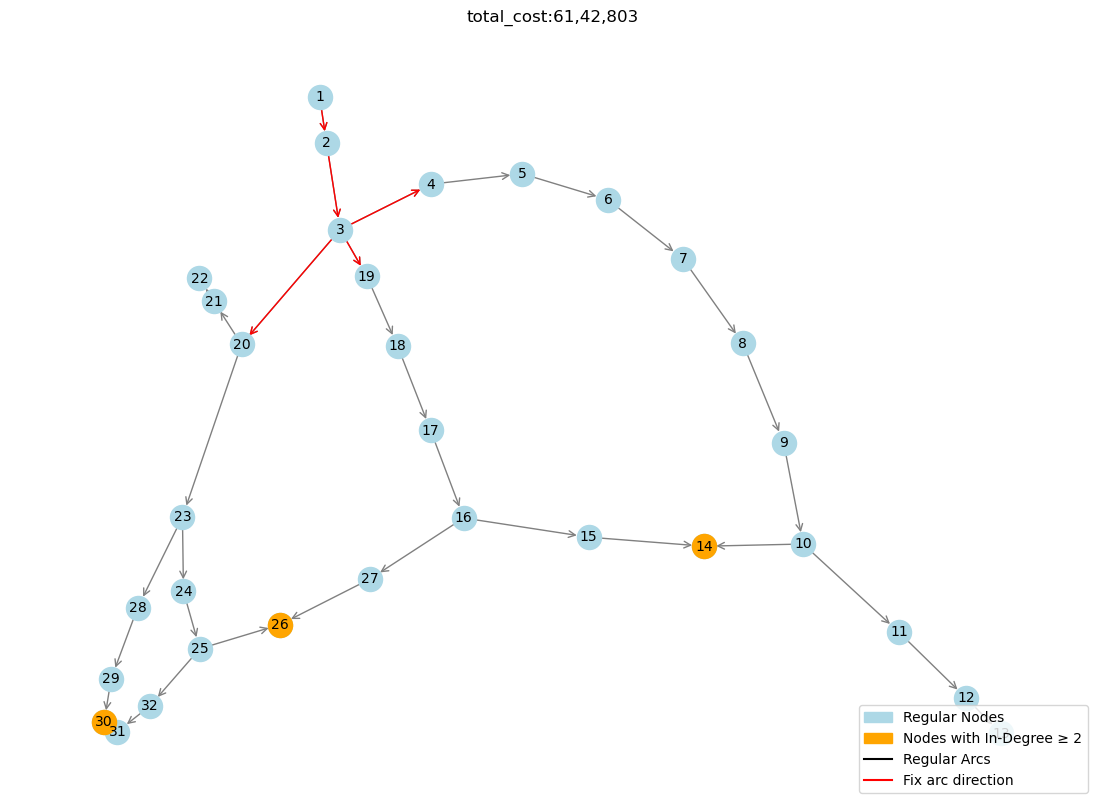

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 26), (25, 32), (27, 26), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
inarc: [(10, 14), (14, 15), (26, 25), (27, 26), (29, 30), (30, 31)]
Edges incoming to node 14: {14: [(10, 14), (15, 14)]}
edge_set_str1: (10,14), (15,14)
Edges incoming to node 26: {14: [(10, 14), (15, 14)], 26: [(25, 26), (27, 26)]}
edge_set_str1: (25,26), (27,26)
Edges incoming to node 30: {14: [(10, 14), (15, 14)], 26: [(25, 26), (27, 26)], 30: [(29, 30), (31, 30)]}
edge_set_str1: (29,30), (31,30)

parameters:   C   D   E   L   P   R   a   b   c   d   delta   omega   p   vmax

sets:
Source        delta_neg14   delta_neg30   nodes
arcs          delta_neg26   inarc_

RuntimeError: Error executing "display" command:
error processing constraint fix_x_14_15:
	invalid subscript x[14,15]


In [16]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self, model_file):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        # self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        # self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        # self.ampl.eval("display h;")
        # self.ampl.eval("display solve_result;")
        # self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")
        self.ampl.eval("display con2.dual;")
                                                                            
    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()

    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()
        
    def plot_graph2(self, super_source_out_arc=None, best_arc=None, current_cost=None, iteration=1):
        new_positions0 = {
         2 : (2000.00, 3000.00),
         3 : (1000.00, 3000.00),        
         4 : (2000.00, 2000.00),        
         5 : (1000.00, 2000.00),       
         6 : (2000.00, 1000.00),       
         7 : (1000.00, 1000.00),      
         1 : (3000.00, 3000.00)     
        }  
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(8, 6))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Annotate node demands
        # for node, (x, y) in pos.items():
        #     demand = self.network_graph.nodes[node].get('demand', 0)  # Get node demand, default to 0
        #     plt.text(x, y + 0.05, f"{demand}", fontsize=8, ha='center', color='blue')  # Annotate demand above the node

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='black', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1, label='Best arc')

        # Annotate edge weights
        for u, v, data in self.network_graph.edges(data=True):
            weight = data.get('weight', 0)  # Get edge weight, default to 0
            mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
            mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
            plt.text(mid_x, mid_y, f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge

        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line, best_edge_line], loc='lower right')

        # Display total cost in the title
        cost = round(self.total_cost)
        plt.title(f"Total Cost: {'{:,}'.format(cost)}")

        # Save the plot
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        # pos = new_positions1
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge

        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     

    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)  
        D = self.ampl.getParameter('D').getValues().to_dict()  

        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] += flow_value
                        # print(f"Fixing flow for arc {edge}: {flow_value}")

                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            # print(f"Fixing flow for arc {edge}: {flow_value}")
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = D[leaf]
                            D[neighbor] += flow_value
                            # print(f"Fixing flow for arc {edge}: {flow_value}")
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")

                        # self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {-flow_value};")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)                    
               
        # print("All leaf arc flows have been fixed.")

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        # self.load_model(self.model_file)
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three
    
    def multistart(self, inarc, current_cost, best_acyclic_flow, improved, super_source_out_arc, iteration):
        max_l = max(self.ampl.getParameter('L').to_dict().values())
        max_q = self.ampl.getParameter('D').getValues().toDict()
        # print(max_q[1])
        # for i, value in max_q.items():
        #     print(value)
        
        source = self.ampl.getSet('Source').to_list()
        E = self.ampl.getParameter('E').getValues().toDict()
        P = self.ampl.getParameter('P').getValues().toDict()
        
        # Define the number of starts for multistart heuristic
        num_starts = 10
        
        # Set a random seed for reproducibility
        random.seed(num_starts)
        
        # Loop for multistart heuristic
        for start in range(num_starts):
            
            for (i,j) in self.ampl.get_set("arcs").to_list():
                for k in self.ampl.get_set("pipes").to_list():
                    value = random.uniform(0, max_l)  
                    self.ampl.eval(f' let l[{i},{j},{k}] := {value};')
                    
            for (i,j) in self.network_graph.edges:
                if (i,j) not in inarc:
                    if (i,j) in self.ampl.get_set("arcs").to_list():
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
                else:
                    if (i,j) in self.ampl.get_set("arcs").to_list():
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
            
            # for (i,j) in self.ampl.get_set("arcs").to_list():
            #     value = random.uniform(max_q[1], -max_q[1])  
            #     self.ampl.eval(f'let q[{i},{j}] := {value};')
            
            for i in self.ampl.get_set("nodes").to_list():
                value = random.uniform(E[i]+P[i], E[source[0]])  
                self.ampl.eval(f'let h[{i}] := {value};')
                
            self.ampl.set_option("solver", "ipopt")
            self.ampl.set_option("ipopt_options", "outlev = 0")
            # ampl.option[""]
            self.ampl.solve()
            
            if self.ampl.solve_result == 'solved':
                cost = self.ampl.get_objective("total_cost").value()
                print(cost)
                
                # Update the best solution if the current cost is lower
                if cost < current_cost:
                    improved = True
                    current_cost = cost
                    self.generate_random_acyclic_from_solution()
                    best_acyclic_flow = self.network_graph.copy()
                    l = self.ampl.getVariable('l').getValues().to_dict()
                    q = self.ampl.getVariable('q').getValues().to_dict()
                    h = self.ampl.getVariable('h').getValues().to_dict()
                    D = self.ampl.getParameter('D').getValues().to_dict()
                    self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                    # print(best_acyclic_flow, improved, current_cost, l, q, h)
        return best_acyclic_flow, improved, current_cost, l, q, h
        
    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        
        # BEST_ARC.append(best_arc)
        # print(q)
        
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        # con2 = self.ampl.get_constraint('con2')
        # con2_dual = con2.get_values('dual').to_dict()
        # print(f"Dual value for 'con2': {dual_value}")
        
        # arc_set = self.ampl.getSet('arcs').to_list()
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
        
        self.load_model(self.model_file)
        # self.update_initial_points(l, q, h)
        
        variables = []
        for (i, j) in inarc:
            if (i, j) in edges_list:
                variables.append(f"({i},{j})")
            else:
                variables.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        variables_str = ", ".join(variables)
        
        # Define the binary variables for the constructed list in AMPL
        self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        self.ampl.eval("var x {inarc_pairs} binary;")
        
        for edge in self.network_graph.edges:
            i, j = edge
            if (i,j) not in inarc:
                if edge in edges_list:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                else:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
        
        for (i, j) in inarc:
            if (i, j) in edges_list:
                self.ampl.eval(f'let x[{i},{j}] := 0;')
                self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{i},{j}] <=  (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
                self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}]);")
            else:
                self.ampl.eval(f'let x[{j},{i}] := 1;')
                self.ampl.eval(f"s.t. flow_bound_right{j}_{i}: q[{j},{i}] <=  (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
                self.ampl.eval(f"s.t. flow_bound_left{j}_{i}: q[{j},{i}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]);")
        
        incoming_edges = {}  # Dictionary to store edges for each node
        
        for node in indegree_2_or_more:
            incoming_edges[node] = list(self.network_graph.in_edges(node, data=False))
            print(f"Edges incoming to node {node}:", incoming_edges)
            edge_set_str1 = ", ".join([f"({u},{v})" for u, v in incoming_edges[node]])
            print("edge_set_str1:",edge_set_str1)
            self.ampl.eval(f"set delta_neg{node} := {{{edge_set_str1}}};")
        
        for node in indegree_2_or_more:
            indeg = self.network_graph.in_degree(node)
            self.ampl.eval(f"s.t. binary_con_{node}: 1 <= (sum{{(i,{node}) in delta_neg{node}: (i,{node}) in arcs}} x[i,{node}])  + (sum{{(j,{node}) in delta_neg{node}: ({node},j) in arcs}} (1-x[{node},j])) <= {indeg-1};")
            # self.ampl.eval(f"s.t. binary_con_{node}: 1 <= (sum{{(i,j) in delta_neg{node}: (i,j) in arcs}} x_{i}_{j})  + (sum{{(i,j) in delta_neg{node}: (j,i) in arcs}} (1-x_{j}_{i})) <= {indeg-1};")
        
        self.ampl.eval("show;")
        constraint_name = "binary_con_14"
        
        # Get the specific constraint by name
        # constraint = self.ampl.get_constraint(constraint_name)
        # print(constraint.to_string())  # Outputs the full representation of the constraint
        self.ampl.eval(f"expand {constraint_name};")
        
        # Step 1: Solve the relaxed problem using IPOPT
        self.solve()  # IPOPT will solve the relaxed problem
        
        x_continuous = self.ampl.getVariable('x').getValues().to_dict()
        best_solution = None
        best_objective = float('inf')
        
        # Step 2: Initialize the branch-and-bound stack with the root problem
        subproblems = []
        subproblems.append({'fixed_vars': {}, 'objective_bound': float('inf')})
        
        while subproblems:
            # Get the current subproblem
            subproblem = subproblems.pop()
            fixed_vars = subproblem['fixed_vars']
            inarc = []
            for node in indegree_2_or_more:
                for (u, v) in list(self.network_graph.in_edges(node)):
                    if (u, v) in edges_list:
                        inarc.append((u,v))
                    else:
                        inarc.append((v,u))
            print("inarc:", inarc)
            
            self.load_model(self.model_file)
            # self.update_initial_points(l, q, h)
            
            variables = []
            for (i, j) in inarc:
                if (i, j) in edges_list:
                    variables.append(f"({i},{j})")
                else:
                    variables.append(f"({j},{i})")
            
            # Convert the list into a string compatible with AMPL
            variables_str = ", ".join(variables)
            
            # Define the binary variables for the constructed list in AMPL
            self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
            self.ampl.eval("var x {inarc_pairs} binary;")
            
            for edge in self.network_graph.edges:
                i, j = edge
                if (i,j) not in inarc:
                    if edge in edges_list:
                        self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                    else:
                        self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
            
            for (i, j) in inarc:
                if (i, j) in edges_list:
                    # self.ampl.eval(f'let x[{i},{j}] := 0;')
                    self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{i},{j}] <=  (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
                    self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}]);")
                else:
                    # self.ampl.eval(f'let x[{j},{i}] := 1;')
                    self.ampl.eval(f"s.t. flow_bound_right{j}_{i}: q[{j},{i}] <=  (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
                    self.ampl.eval(f"s.t. flow_bound_left{j}_{i}: q[{j},{i}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]);")
            
            # Step 3: Apply fixed variables to the model
            for (i, j), value in fixed_vars.items():
                print((i,j), value)
                self.ampl.eval(f"fix_x_{i}_{j}: x[{i},{j}] = {value};")
            
            # Solve the relaxed problem for the current subproblem
            self.solve()
            x_current = self.ampl.getVariable('x').getValues().to_dict()
            current_objective = self.ampl.getObjective('total_cost').value()
            
            # Step 4: Check feasibility and update best solution
            is_integer = all(abs(value - round(value)) < 1e-5 for value in x_current.values())
            if self.solve_result == 'solved':
                if is_integer:
                    # Update the best solution if the current one is better
                    if current_objective < best_objective:
                        best_objective = current_objective
                        best_solution = x_current
                        self.generate_random_acyclic_from_solution()
                        # best_acyclic_flow = self.network_graph.copy()
                
                # Step 5: Branch if the solution is not integer
                for (i, j), value in x_current.items():
                    if abs(value - round(value)) >= 1e-5:  # Non-integer variable
                        lower_branch = fixed_vars.copy()
                        upper_branch = fixed_vars.copy()

                        lower_branch[(i, j)] = 0  # Fix to lower integer
                        upper_branch[(i, j)] = 1  # Fix to upper integer

                        # Add subproblems to the stack
                        subproblems.append({'fixed_vars': lower_branch, 'objective_bound': current_objective})
                        subproblems.append({'fixed_vars': upper_branch, 'objective_bound': current_objective})

                        # Break after branching on the first non-integer variable
                        break

        # Output the best integer solution
        print("Best Integer Solution:", best_solution)
        print("Objective Value:", best_objective)
        self.total_cost = best_objective
        # q = self.ampl.getVariable('q').getValues().to_dict()
        # print("flow", q)
        
        self.generate_random_acyclic_from_solution()
        if self.solve_result == "solved":
            # arc = (u,v)
            if self.total_cost < current_cost:
                print("Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
                current_cost = self.total_cost
                improved = True
                best_acyclic_flow = self.network_graph.copy()
                # best_arc = (v,u)
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                D = self.ampl.getParameter('D').getValues().to_dict()
                
                # self.ampl.eval(f"display x;")
                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                
                # self.network_graph.remove_edge(v, u)
                # self.network_graph.add_edge(u, v)
                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
            else:
                print("Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
                # self.network_graph.remove_edge(v, u)
                # self.network_graph.add_edge(u, v)

        # for node in indegree_2_or_more:
        #     for (u, v) in list(self.network_graph.in_edges(node)):
        #         if (u,v) in arc_set:
        #             print(f"con2_dual[{u},{v}]", con2_dual[(u,v)])
        #         else:
        #             print(f"con2_dual[{u},{v}]", con2_dual[(v,u)])
        
        # con6 = self.ampl.get_constraint('con6')
        # con6_dual = con6.get_values('dual').to_dict()
        
        # for i in indegree_2_or_more:
        #     print(f"con6_dual[{i}]:",con6_dual[i])
        
        # dictionary = {i: con6_dual[i] for i in indegree_2_or_more}
        # Keymax = max(dictionary, key= lambda x: dictionary[x])
        # print("maxIndex:",Keymax)
        
        # C_values = self.ampl.getParameter('C').getValues().to_dict()  
        # pipes = self.ampl.getSet('pipes').to_list()
        # print("l:",l)
        
        # Step 3: Compute weights for given arcs
        # arc_weights_l = {}
        
        # for node in indegree_2_or_more:
        #     for (i, j) in list(self.network_graph.in_edges(node)):
        #         weight = 0
        #         for k in pipes:
        #             if (i,j,k) in l.keys():
        #                 weight += l[i, j, k] * C_values[k]  # Compute weight
        #             else:
        #                 weight += l[j, i, k] * C_values[k]  # Compute weight
        #         arc_weights_l[i,j] = weight
        
            # self.network_graph[i][j]['weight'] = weight  # Assign weight to edge
        
        # undirected_graph = self.network_graph.to_undirected()
        
        # mst = nx.minimum_spanning_tree(undirected_graph, algorithm='kruskal')
        # print("Minimum spanning tree is",mst.edges() )
        # print(" ")
        # Step 5: Find edges not in MST
        # original_edges = set(undirected_graph.edges())
        # mst_edges = set(mst.edges())
        # edges_not_in_mst = original_edges - mst_edges

        # Step 6: Output results
        # print("Arc weights:", arc_weights)
        # print("Minimum Spanning Tree Edges:", mst.edges(data=True))
        # print("Edges not in MST:", edges_not_in_mst)
        # edges_not_in_mst = edges_not_in_mst - set(super_source_out_arc)
        # print("Edges not in MST:", edges_not_in_mst)
        
        # arc_set = self.ampl.getSet('arcs').to_list()
        # arc_weights = {}
        # for node in indegree_2_or_more:
        #     for (u, v) in list(self.network_graph.in_edges(node)):
        #          arc_weights[u,v] = (h[u] - h[v])
        # print(arc_weights)
        # (u,v) = min(arc_weights, key= lambda x: arc_weights[x])
        # print("best reversal arc:",(u,v))
                
#         self.network_graph.remove_edge(u,v)
#         self.network_graph.add_edge(v,u)
#         acy_check = nx.is_directed_acyclic_graph(self.network_graph)
#         in_arc_check = self.check_incoming_arcs()
#         if acy_check and in_arc_check:
#             #l_sol, q_sol, h_sol = self.generate_initial_points()
#             self.load_model(self.model_file)
#             # self.load_model("../mccormic_rel.mod")
#             self.update_initial_points(l, q, h)
#             self.update_model()
#             self.fix_leaf_arc_flow()
#             self.solve()
#             # print("cost:", self.total_cost)
#             # self.display_results()
#             # self.ampl.eval(f"display con2[{u},{v}].dual;")
#             if self.solve_result == "solved":
#                 arc = (u,v)
#                 # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#                 if self.total_cost < current_cost:
#                     print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                     current_cost = self.total_cost
#                     improved = True
#                     best_acyclic_flow = self.network_graph.copy()
#                     best_arc = (v,u)

#                     l = self.ampl.getVariable('l').getValues().to_dict()
#                     q = self.ampl.getVariable('q').getValues().to_dict()
#                     h = self.ampl.getVariable('h').getValues().to_dict()
#                     D = self.ampl.getParameter('D').getValues().to_dict()

#                     self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)

#                     self.network_graph.remove_edge(v, u)
#                     self.network_graph.add_edge(u, v)
#                 else:
#                     print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                     self.network_graph.remove_edge(v, u)
#                     self.network_graph.add_edge(u, v)
#             else:
#                 print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#         else:
#             print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
#             self.network_graph.remove_edge(v, u)
#             self.network_graph.add_edge(u, v)
#         print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
        # topo_order = list(nx.topological_sort(self.network_graph))
        # print(topo_order)
#         cost_dict = {}
#         for node in indegree_2_or_more:
#             print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
#             for u,v in list(self.network_graph.in_edges(node)):
#                 if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
#                     self.network_graph.remove_edge(u,v)
#                     self.network_graph.add_edge(v,u)
#                     acy_check = nx.is_directed_acyclic_graph(self.network_graph)
#                     in_arc_check = self.check_incoming_arcs()
#                     if acy_check and in_arc_check:
#                         #l_sol, q_sol, h_sol = self.generate_initial_points()
#                         self.load_model("../lpNlp/new_lp.mod")
#                         # self.load_model("../mccormic_rel.mod")
#                         # self.update_initial_points(l, q, h)
#                         self.update_model()
#                         self.fix_leaf_arc_flow()
#                         self.ampl.option["solver"] = "cplexamp"
#                         # lp_ampl.option["ipopt_options"]="outlev 1"
#                         self.ampl.solve()
#                         q_lp = self.ampl.getVariable('q').getValues().to_dict()

#                         self.load_model("../lpNlp/lp_model.mod")
#                         # self.fix_leaf_arc_flow()
                                                
#                         for (i, j), value in q_lp.items():
#                             self.ampl.param['q_lp'][i, j] = value
                            
#                         self.ampl.option["solver"] = "cplexamp"
#                         # lp_ampl.option["ipopt_options"]="outlev 1"
#                         self.ampl.solve()
                        
#                         # lp_ampl.eval("display total_cost;")
#                         totalcost = self.ampl.get_objective("total_cost")
#                         print("Objective is:", totalcost.value())
                        
#                         # print("cost:", self.total_cost)   
#                         # self.display_results()
#                         # self.ampl.eval(f"display con2[{u},{v}].dual;")
#                         if self.solve_result == "solved":
#                             cost_dict[u,v] = totalcost.value()
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)
#                         else:
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)
#                     else:
#                         self.network_graph.remove_edge(v, u)
#                         self.network_graph.add_edge(u, v)

#         (u,v) = max(cost_dict, key= lambda x: cost_dict[x])
#         print("best reversal arc:",(u,v)) 
        
#         self.network_graph = best_acyclic_flow.copy()
        
#         self.network_graph.remove_edge(u,v)
#         self.network_graph.add_edge(v,u)

#         #l_sol, q_sol, h_sol = self.generate_initial_points()
#         self.load_model(self.model_file)
#         # self.load_model("../mccormic_rel.mod")
#         self.update_initial_points(l, q, h)
#         self.update_model()
#         self.fix_leaf_arc_flow()
#         self.solve()
#         # print("cost:", self.total_cost)
#         # self.display_results()
#         # self.ampl.eval(f"display con2[{u},{v}].dual;")
#         if self.ampl.solve_result == "solved":
#             arc = (u,v)
#             # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#             if self.total_cost < current_cost:
#                 print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                 current_cost = self.total_cost
#                 improved = True
#                 best_acyclic_flow = self.network_graph.copy()
#                 best_arc = (v,u)

#                 l = self.ampl.getVariable('l').getValues().to_dict()
#                 q = self.ampl.getVariable('q').getValues().to_dict()
#                 h = self.ampl.getVariable('h').getValues().to_dict()
#                 D = self.ampl.getParameter('D').getValues().to_dict()

#                 self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)

#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#             else:
#                 # best_acyclic_flow = self.network_graph.copy()
#                 print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#         else:
#             print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#             self.network_graph.remove_edge(v, u)
#             self.network_graph.add_edge(u, v)

#         print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc 

        # for node in indegree_2_or_more:
        #     print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
        #     for u,v in list(self.network_graph.in_edges(node)):
        #         if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
        #             self.network_graph.remove_edge(u,v)
        #             self.network_graph.add_edge(v,u)
        #             acy_check = nx.is_directed_acyclic_graph(self.network_graph)
        #             in_arc_check = self.check_incoming_arcs()
        #             if acy_check and in_arc_check:
        #                 #l_sol, q_sol, h_sol = self.generate_initial_points()
        #                 self.load_model(self.model_file)
        #                 self.update_initial_points(l, q, h)
        #                 self.update_model()
        #                 self.solve()
        #                 # print("cost:", self.total_cost)   
        #                 # self.display_results()
        #                 if self.solve_result == "solved":
        #                     arc = (u,v)
        #                     if self.total_cost < current_cost:
        #                         print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
        #                         current_cost = self.total_cost
        #                         improved = True
        #                         best_acyclic_flow = self.network_graph.copy()
        #                         best_arc = (v,u)
        #                         l = self.ampl.getVariable('l').getValues().to_dict()
        #                         q = self.ampl.getVariable('q').getValues().to_dict()
        #                         h = self.ampl.getVariable('h').getValues().to_dict()
        #                         D = self.ampl.getParameter('D').getValues().to_dict()
        #                         self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                         # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
        #                     else:
        #                         print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                 else:
        #                     print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
        #                     self.network_graph.remove_edge(v, u)
        #                     self.network_graph.add_edge(u, v)                         
        #             else:
        #                 print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
        #                 self.network_graph.remove_edge(v, u)
        #                 self.network_graph.add_edge(u, v)                      
        #     print(" ")
        
        return best_acyclic_flow, improved, current_cost, l, q, h
     
#                             if self.solve_result == "solved":
#                             arc = (u,v)
#                             # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#                             if self.total_cost < current_cost:
#                                 print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                                 current_cost = self.total_cost
#                                 improved = True
#                                 best_acyclic_flow = self.network_graph.copy()
#                                 best_arc = (v,u)
                                
#                                 l = self.ampl.getVariable('l').getValues().to_dict()
#                                 q = self.ampl.getVariable('q').getValues().to_dict()
#                                 h = self.ampl.getVariable('h').getValues().to_dict()
#                                 D = self.ampl.getParameter('D').getValues().to_dict()
                                
#                                 self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
                                
#                                 self.network_graph.remove_edge(v, u)
#                                 self.network_graph.add_edge(u, v)  
#                             else:
#                                 print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                                 self.network_graph.remove_edge(v, u)
#                                 self.network_graph.add_edge(u, v)  
#                         else:
#                             print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)                         
#                     else:
#                         print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
#                         self.network_graph.remove_edge(v, u)
#                         self.network_graph.add_edge(u, v)                      
#             print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
            # print("flow values ",q)
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            # """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes least_square_init_duals = no tol=1e-9 ")   #max_iter = 1000
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model(self.model_file)
        self.fix_leaf_arc_flow()
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        P = self.ampl.getParameter('P').getValues().to_dict()
        E = self.ampl.getParameter('E').getValues().to_dict()
        # for i, val in P.items():
        #     print(i, P[i]+E[i])
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print(q_sol)
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()
        
        self.load_model(self.model_file)
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.fix_leaf_arc_flow()
        self.update_model()
        # self.ampl.eval("show `;")
        self.solve()
        # self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

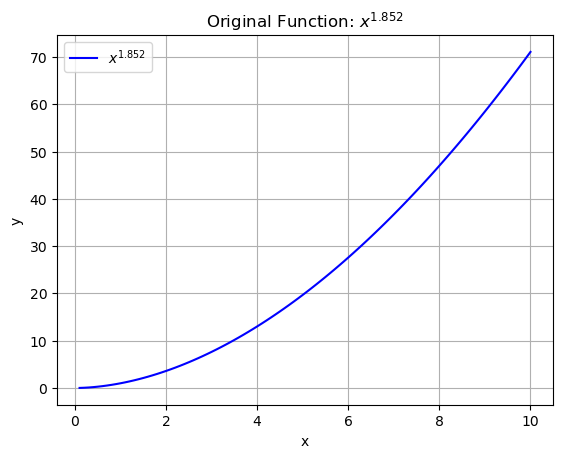

In [620]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
x = np.linspace(0.1, 10, 100)  # Avoid x=0 to prevent issues with fractional exponents
y = x**1.852

# Plot the original function
plt.plot(x, y, label='$x^{1.852}$', color='blue')
plt.title('Original Function: $x^{1.852}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

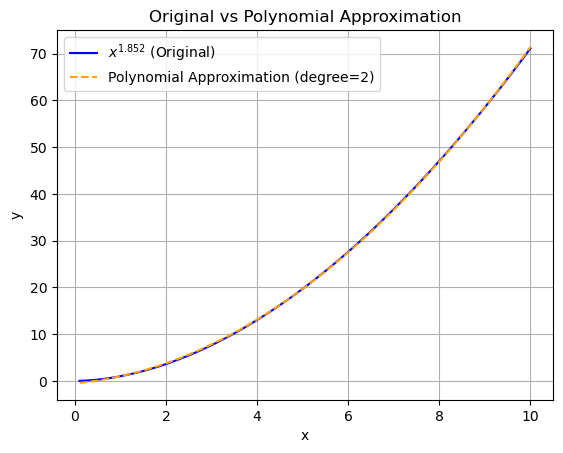

Approximation Equation: y ≈ -0.5324 + 0.8905x + 0.6304x^2


In [621]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit

# Define the function
x = np.linspace(0.1, 10, 100)  # Define x values (avoid x=0 for fractional powers)
y = x**1.852                   # Compute y values for the original function

# Fit a polynomial (degree 2: quadratic)
degree = 2
coeffs = polyfit(x, y, degree)  # Fit the polynomial coefficients

# Generate the polynomial approximation
poly_approx = Polynomial(coeffs)
y_approx = poly_approx(x)

# Plot the original and approximate functions
plt.plot(x, y, label='$x^{1.852}$ (Original)', color='blue')
plt.plot(x, y_approx, label=f'Polynomial Approximation (degree={degree})', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Print the polynomial coefficients
print(f"Approximation Equation: y ≈ {coeffs[0]:.4f} + {coeffs[1]:.4f}x + {coeffs[2]:.4f}x^2")

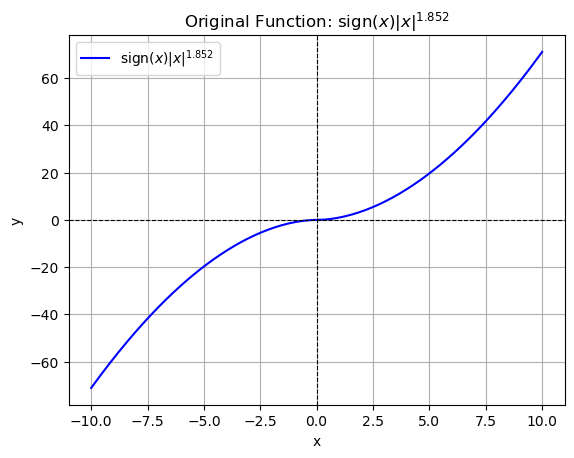

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return np.sign(x) * np.abs(x)**1.852

# Generate data points
x = np.linspace(-10, 10, 200)  # Range includes negative and positive values
y = f(x)

# Plot the original function
plt.plot(x, y, label='$\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.title('Original Function: $\mathrm{sign}(x)|x|^{1.852}$')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

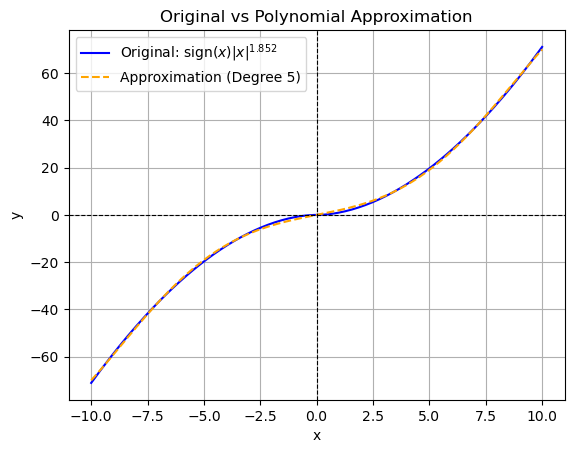

Approximation Equation: y ≈ 1.9138x + 0.0844x^3 + -0.0003x^5


In [623]:
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

# Define the odd polynomial form
def odd_polynomial(x, a1, a3, a5):
    return a1 * x + a3 * x**3 + a5 * x**5

# Generate data points for fitting
x_fit = np.linspace(-10, 10, 200)
y_fit = f(x_fit)

# Fit the odd polynomial (degree 5 in this example)
coeffs, _ = curve_fit(odd_polynomial, x_fit, y_fit, p0=[1, 0, 0])  # Initial guesses

# Generate approximation values
y_approx = odd_polynomial(x_fit, *coeffs)

# Plot the original and approximation
plt.plot(x_fit, y_fit, label='Original: $\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.plot(x_fit, y_approx, label='Approximation (Degree 5)', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Print the polynomial coefficients
print(f"Approximation Equation: y ≈ {coeffs[0]:.4f}x + {coeffs[1]:.4f}x^3 + {coeffs[2]:.4f}x^5")

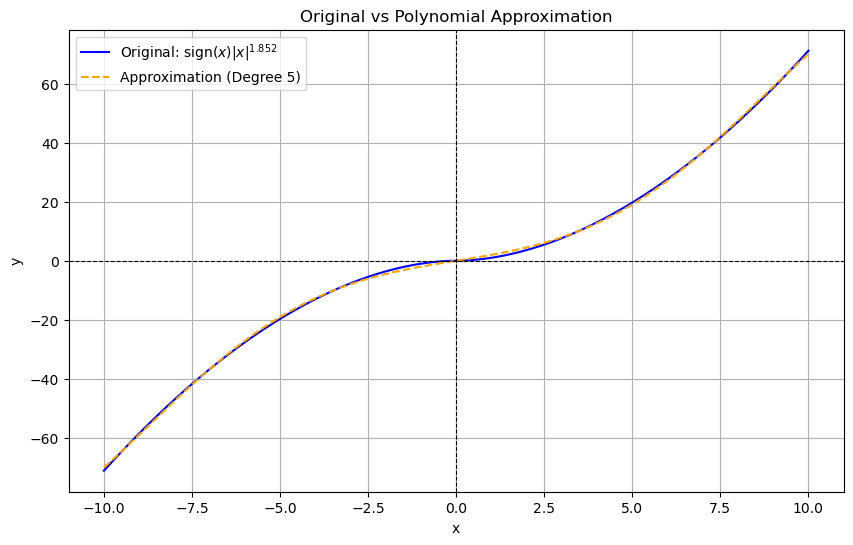

array([ 1.91379410e+00,  8.43990803e-02, -3.35286909e-04])

In [630]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the original function
def f(x):
    return np.sign(x) * np.abs(x)**1.852

# Define the odd polynomial form
def odd_polynomial(x, a1, a3, a5):
    return a1 * x + a3 * x**3 + a5 * x**5

# Generate data points for fitting
x_fit = np.linspace(-10, 10, 200)
y_fit = f(x_fit)

# Fit the odd polynomial (degree 5)
coeffs, _ = curve_fit(odd_polynomial, x_fit, y_fit, p0=[1, 0, 0])  # Initial guesses

# Generate approximation values
y_approx = odd_polynomial(x_fit, *coeffs)

# Plot the original and approximation
plt.figure(figsize=(10, 6))
plt.plot(x_fit, y_fit, label='Original: $\\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.plot(x_fit, y_approx, label='Approximation (Degree 5)', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Output the coefficients of the polynomial
coeffs

In [509]:
import matplotlib.pyplot as plt
import numpy as np

# Data
instances = [
    "d_1", "d_2", "d_3", "d_4", "d_5", 
    "d_6", "d_7", "d_8", "d_9", "d_10", 
    "d_11", "d_12", "d_13", "d_14", "d_15", "d_16"
]
objectives_best_solution = [
    403404.3256, 6058195.193, 12064445.12, 18369653.18, 8818776.684, 
    3553591.035, 3392582.223, 6887885.814, 8.87E+06, 9.48E+06, 
    10952208.55, 3397712.797, 14896324.02, 66399735.69, 171724.3325, 2.03E+04
]
times_best_solution = [
    0.706489, 0.169, 3607.58, 3.18, 3606.21, 46.307574, 3600.79, 3600.73, 
    62.024584, 6.50006, 3.993, 3600.8, 0.033, 1.283074, 1.14, 54.106611
]
objectives_heuristic = [
    403404.3254, 6055935.777, 12064445.01, 18369652.94, 8814597.898, 
    3583561.278, 3392581.16, 6970574.798, 8866820.221, 9401091.06, 
    10703347.71, 3409150.229, 14896324.02, 66444650.62, 171724.4017, 20194.20323
]
times_heuristic = [
    0.8359925747, 1.694795609, 7.378664732, 15.10105038, 5.318006039, 
    92.42892265, 122.3781023, 19.76274657, 608.2187338, 1041.154208, 
    775.5673153, 220.4401248, 0.4528565407, 28.14932442, 45.25914669, 30.79383755
]

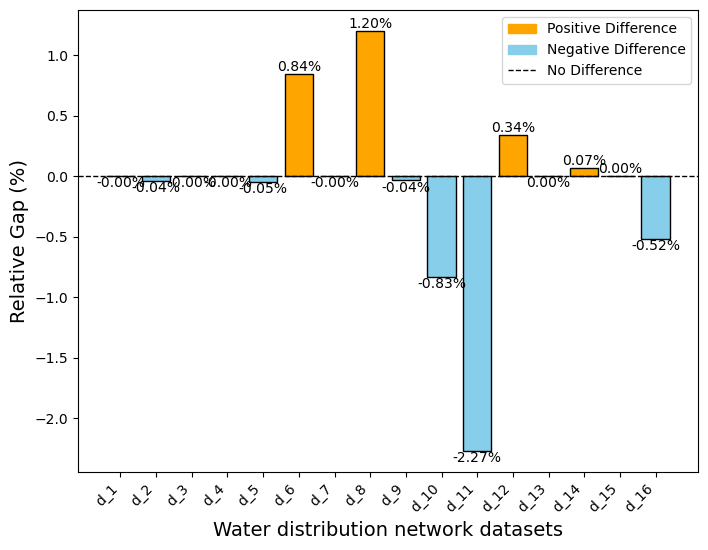

In [525]:
# Calculate relative differences
relative_difference = [
    ((heuristic - best) / best) * 100 
    for heuristic, best in zip(objectives_heuristic, objectives_best_solution)
]

# Plot Relative Differences with Color for Positive and Negative Differences
plt.figure(figsize=(8, 6))

# Color bars based on relative difference sign
colors = ['skyblue' if diff < 0 else 'orange' for diff in relative_difference]
bars = plt.bar(instances, relative_difference, color=colors, edgecolor='black')

# Annotate values on the bars
for bar, diff in zip(bars, relative_difference):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f"{diff:.2f}%", 
        ha='center', va='bottom' if height > 0 else 'top', fontsize=10
    )

plt.axhline(0, color='black', linestyle='--', linewidth=1, label="No Difference")

# Create custom legend handles
positive_patch = mpatches.Patch(color='orange', label="Positive Difference")
negative_patch = mpatches.Patch(color='skyblue', label="Negative Difference")
# Create a dashed line for the "No Difference" legend
no_diff_line = mlines.Line2D([0], [0], color='black', linestyle='--', linewidth=1, label="No Difference")

# Add legends for positive, negative, and no difference
plt.legend(handles=[positive_patch, negative_patch, no_diff_line], loc="upper right")

formula_text = r'$\frac{(Objective_{heuristic} - Objective_{best})}{Objective_{best}} \times 100$'
# plt.ylabel(f"Relative Difference (%)\n{formula_text}", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Water distribution network datasets", fontsize=14)
plt.ylabel("Relative Gap (%)", fontsize=14)
# plt.title("Relative Gap in Objective Values (Heuristic vs. Best Solution)",color='magenta', fontsize=16)
# plt.grid(axis='y')
plt.show()

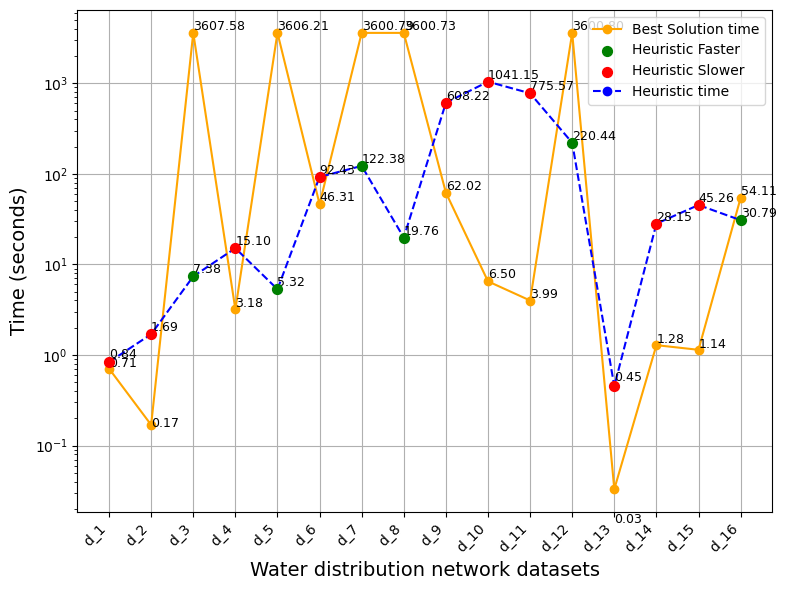

In [524]:
import matplotlib.pyplot as plt
import numpy as np

# Data
instances = [
    "d_1", "d_2", "d_3", "d_4", "d_5", 
    "d_6", "d_7", "d_8", "d_9", "d_10", 
    "d_11", "d_12", "d_13", "d_14", "d_15", "d_16"
]
times_best_solution = [
    0.706489, 0.169, 3607.58, 3.18, 3606.21, 46.307574, 3600.79, 3600.73, 
    62.024584, 6.50006, 3.993, 3600.8, 0.033, 1.283074, 1.14, 54.106611
]
times_heuristic = [
    0.8359925747, 1.694795609, 7.378664732, 15.10105038, 5.318006039, 
    92.42892265, 122.3781023, 19.76274657, 608.2187338, 1041.154208, 
    775.5673153, 220.4401248, 0.4528565407, 28.14932442, 45.25914669, 30.79383755
]

# Plot Times using a log scale for better visibility of variations
plt.figure(figsize=(8, 6))

# Plot the Best Solution points
plt.plot(times_best_solution, label="Best Solution time", marker='o', color='orange')

# Plot the Heuristic points with different colors based on time comparison
faster_idx = [i for i in range(len(times_heuristic)) if times_heuristic[i] < times_best_solution[i]]
slower_idx = [i for i in range(len(times_heuristic)) if times_heuristic[i] >= times_best_solution[i]]

# Plot green points where heuristic is faster
plt.scatter(faster_idx, [times_heuristic[i] for i in faster_idx], color='green', label="Heuristic Faster", zorder=5, s=50)

# Plot red points where heuristic is slower
plt.scatter(slower_idx, [times_heuristic[i] for i in slower_idx], color='red', label="Heuristic Slower", zorder=5, s=50)

# Plot the Heuristic line for completeness
plt.plot(times_heuristic, label="Heuristic time", marker='o', linestyle='--', color='blue')

# Annotate each point with its time value
for i in range(len(times_heuristic)):
    offset_y =  0.02  # Proportional offset
    if times_heuristic[i] < times_best_solution[i]:
        plt.text(i, times_heuristic[i] - offset_y, f"{times_heuristic[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')
    else:
        plt.text(i, times_heuristic[i] + offset_y, f"{times_heuristic[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')

# Annotate Best Solution points
for i in range(len(times_best_solution)):
    offset_y = 0.02  # Proportional offset
    plt.text(i, times_best_solution[i] - offset_y, f"{times_best_solution[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')

# Set the y-axis to a logarithmic scale
plt.yscale("log")

# Set the x-ticks and labels for the instances
plt.xticks(np.arange(len(instances)), labels=instances, rotation=45, ha="right")

# Add labels and title
plt.xlabel("Water distribution network datasets", fontsize = 14)
plt.ylabel("Time (seconds)", fontsize=14)
# plt.title("Comparison of Time Taken")

# Add the legend
plt.legend()

# Display grid
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()
